# Creating Container for Simulated Data
In this notebook, I want to derive a HDF5 container for a given simulated network (simulated by `NetSim`). For that, I have to create simulated feature vectors and a training and test split.
The results should then be put in a HDF5 container.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import h5py
np.set_printoptions(precision=1, suppress=True)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
# params
test_ratio = .3
pos_distr = (20, 70) # mean and variance
neg_distr = (20, 70) # mean and variance
num_features = 24

## Load Network and Insert Positions from Disk

In [17]:
# read the network and insert positions
network = nx.read_edgelist('../data/simulation/network.edgelist')
insert_positions = []
with open('../data/simulation/implant_positions.txt', 'r') as f:
    for line in f.readlines():
        if line.startswith('#'): # comment
            pass
        elif line.startswith('Subnetwork'):
            positions = line.split(':')[1].strip().split('\t')
            insert_positions.append([int(i) for i in positions])
print (network.number_of_nodes(), network.number_of_edges())

1053 2275


In [18]:
list_of_cliques = list(nx.find_cliques(network))
count = 0
for c in list_of_cliques:
    c_i = [int(j) for j in c]
    for i in insert_positions:
        if set(c_i) == set(i):
            count += 1
print ("Found {} cliques in insert positions and in the network".format(count))

Found 38 cliques in insert positions and in the network


## Assign Feature Vector

In [19]:
num_nodes = network.number_of_nodes()
all_clique_nodes = np.array(insert_positions).reshape(-1)
features = np.random.normal(loc=neg_distr[0], scale=np.sqrt(neg_distr[1]),
                            size=(num_nodes, num_features))
features[all_clique_nodes] = np.random.normal(loc=pos_distr[0], scale=np.sqrt(pos_distr[1]),
                                              size=(all_clique_nodes.shape[0], num_features))
not_clique_mems = np.array([i for i in np.arange(num_nodes) if not i in all_clique_nodes])
features[features < 0] = 0 # no negative gene expression

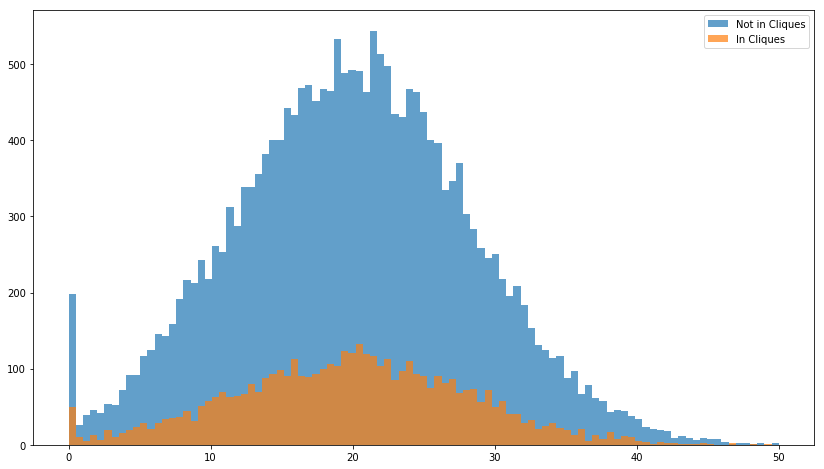

In [20]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(features.min(), features.max(), 100)
_ = plt.hist(features[not_clique_mems].reshape(-1), bins=bins, label='Not in Cliques', normed=False, alpha=.7)
_ = plt.hist(features[all_clique_nodes].reshape(-1), bins=bins, label='In Cliques', normed=False, alpha=.7)
_ = plt.legend()

## Compute Split

In [21]:
y = np.array([1 if i in all_clique_nodes else 0 for i in np.arange(num_nodes)])
print (y.shape, y.sum())
train_nodes, test_nodes = train_test_split(np.arange(num_nodes), test_size=test_ratio, stratify=y)

(1053,) 190


In [22]:
import collections
collections.Counter(np.arange(num_nodes)[y == 1]) == collections.Counter(all_clique_nodes)

True

In [23]:
[i for i in train_nodes if i in test_nodes] # no overlap

[]

In [24]:
# define masks as all train/test nodes
train_mask = np.zeros_like(y)
test_mask = np.zeros_like(y)
train_mask[train_nodes] = 1
test_mask[test_nodes] = 1

# define labels as all the labels that are also in train/test mask
y_train = np.logical_and(train_mask, y)
y_test = np.logical_and(test_mask, y)

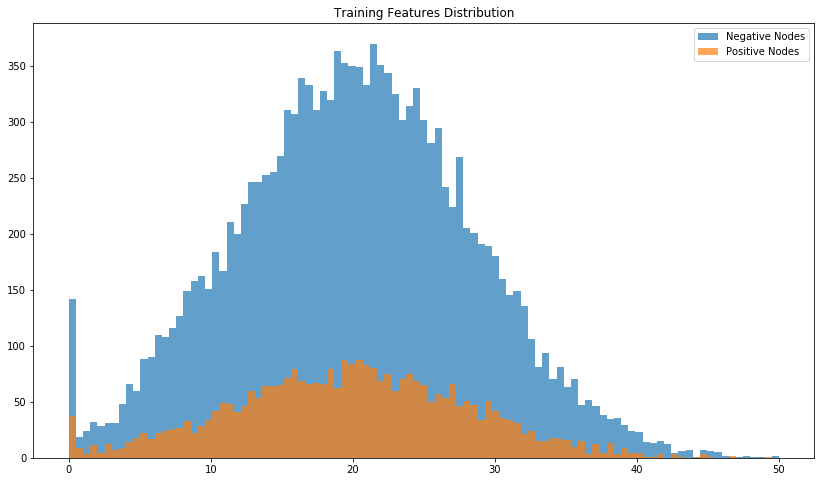

In [25]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(features.min(), features.max(), 100)
_ = plt.hist(features[np.logical_and(y_train == 0, train_mask)].reshape(-1), bins=bins,
             label='Negative Nodes', normed=False, alpha=.7)
_ = plt.hist(features[np.logical_and(y_train == 1, train_mask)].reshape(-1), bins=bins,
             label='Positive Nodes', normed=False, alpha=.7)
_ = plt.legend()
plt.title('Training Features Distribution')

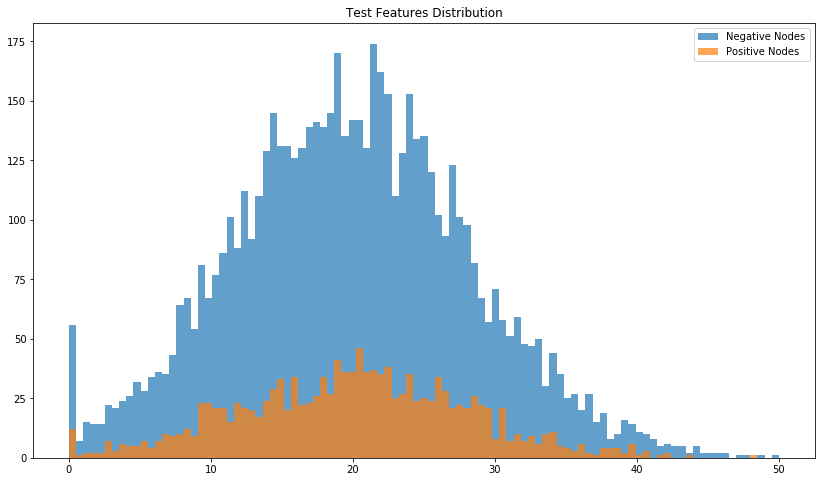

In [26]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(features.min(), features.max(), 100)
_ = plt.hist(features[np.logical_and(y_test == 0, test_mask)].reshape(-1), bins=bins,
             label='Negative Nodes', normed=False, alpha=.7)
_ = plt.hist(features[np.logical_and(y_test == 1, test_mask)].reshape(-1), bins=bins,
             label='Positive Nodes', normed=False, alpha=.7)
_ = plt.legend()
plt.title('Test Features Distribution')

## Write to HDF5 container

In [27]:
node_names = np.arange(num_nodes)
node_names = np.vstack([node_names, node_names]).transpose(1, 0) # just stack node numbers
node_names

array([[   0,    0],
       [   1,    1],
       [   2,    2],
       ...,
       [1050, 1050],
       [1051, 1051],
       [1052, 1052]])

In [28]:
y_train = y_train.reshape(num_nodes, 1)
y_test = y_test.reshape(num_nodes, 1)

network_np = nx.to_numpy_matrix(network, nodelist=[str(i[0]) for i in node_names])
node_names = np.arange(num_nodes)
node_names = np.vstack([node_names, node_names]).transpose(1, 0) # just stack node numbers

f = h5py.File('../data/simulation/simulated_all_unbalanced.h5', 'w')
f.create_dataset('network', data=network_np, shape=network_np.shape)
f.create_dataset('features', data=features, shape=features.shape)
f.create_dataset('gene_names', data=node_names, shape=node_names.shape)

f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
f.close()

## Make sure that Data is Correct

In [ ]:
network_recon = nx.from_numpy_matrix(nx.to_numpy_matrix(network,
                                                        nodelist=[str(i[0]) for i in node_names]))
list_of_cliques = np.array([i for i in list(nx.find_cliques(network)) if len(i) >= 5],
                           dtype=np.int64).flatten()
fig = plt.figure(figsize=(14, 8))
mask = np.zeros(features.shape[0])
mask[list_of_cliques] = 1
mask = mask.astype(np.bool)
#mask = np.logical_or(y_train, y_test)
df_f = pd.DataFrame(features)
seaborn.distplot(df_f[mask].values.flatten(), norm_hist=False, label='Positive')
seaborn.distplot(df_f[~mask].values.flatten(), norm_hist=False, label='Negative')
plt.legend()

In [ ]:
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
F_train = features[train_mask == 1]
emb = PCA(n_components=2).fit_transform(F_train)
plt.scatter(emb[:, 0], emb[:, 1], c=y_train[train_mask == 1], cmap=plt.cm.copper)

plt.subplot(2, 1, 2)
F_test = features[test_mask == 1]
emb = PCA(n_components=2).fit_transform(F_test)
plt.scatter(emb[:, 0], emb[:, 1], c=y_test[test_mask == 1], cmap=plt.cm.copper)

In [ ]:
df = pd.DataFrame(features)
df[y == 1].mean().mean(), df[y == 1].var().mean()
df[y == 0].mean().mean(), df[y == 0].var().mean()
df['degree'] = network_np.sum(axis=1)
df['label'] = y

# get betweenness
bet = nx.betweenness_centrality(network)
df['betweenness'] = 0
for k, v in bet.items():
    df.loc[int(k), 'betweenness'] = v

# get core number
core = nx.core_number(network)
df['core'] = 0
for k, v in core.items():
    df.loc[int(k), 'core'] = v

# plot
fig = plt.figure(figsize=(14, 8))
seaborn.violinplot(x='label', y='core', data=df)